In [1]:
# Import statements
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3

In [2]:
# Dataset Directories for Flowers
TRAINING_DIR = "./flowers/train/"
VALIDATION_DIR = "./flowers/val/"

# Flowers Labels
FLOWERS_LABELS = next(os.walk(TRAINING_DIR))[1]
FLOWERS_LABELS.sort()
print(FLOWERS_LABELS)

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


Flowers: astilbe
Training images: 589
Validation images: 737
Sample astilbe image:


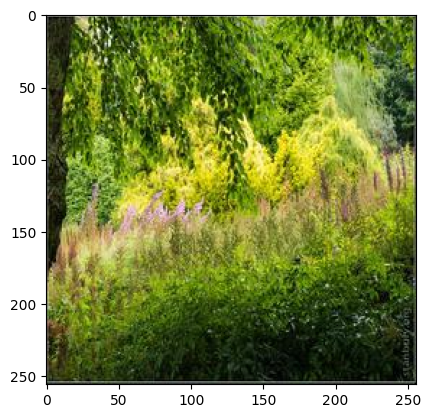


Flowers: bellflower
Training images: 698
Validation images: 873
Sample bellflower image:


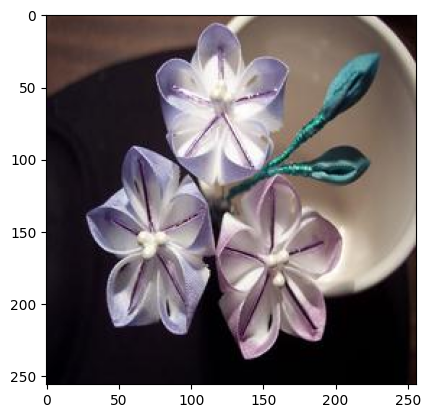


Flowers: black_eyed_susan
Training images: 800
Validation images: 1000
Sample black_eyed_susan image:


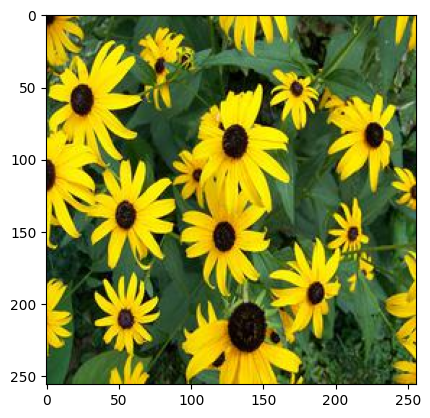

In [3]:
for flowers in FLOWERS_LABELS[0:3]:
    # preparing directories
    train_flowers_dir = os.path.join(TRAINING_DIR, flowers)
    val_flowers_dir = os.path.join(VALIDATION_DIR, flowers)
    # displaying the results
    print(f"Flowers: {flowers}")
    print(f"Training images: {len(os.listdir(train_flowers_dir))}")
    print(f"Validation images: {len(os.listdir(val_flowers_dir))}")
    print(f"Sample {flowers} image:")
    plt.imshow(load_img(f"{os.path.join(train_flowers_dir, os.listdir(train_flowers_dir)[0])}"))
    plt.show()
    print()

In [4]:
def train_val_generators(train_dir, valid_dir, image_size):
    # Train dataset will be augmented as follows
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest')
    # Initialize training generator
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        target_size=(image_size, image_size))

    # Validation dataset will not be augmented
    validation_datagen = ImageDataGenerator(rescale=1./255)
    # Initialize validation generator
    validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                                    batch_size=64,
                                                                    class_mode='categorical',
                                                                    target_size=(image_size, image_size))
    return train_generator, validation_generator

In [5]:
IMAGE_SIZE = 150
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE)

Found 12586 images belonging to 16 classes.
Found 15740 images belonging to 16 classes.


In [6]:
def create_inception_base_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
                                    include_top = False,
                                    weights = None)
    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [8]:
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_base_model = create_inception_base_model(local_weights_file)

In [9]:
def output_of_last_layer(inception_base_model):
    last_desired_layer = inception_base_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

inception_last_layer = output_of_last_layer(inception_base_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [10]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(16, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [11]:
model = create_final_model(inception_base_model, inception_last_layer)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,527,856 total parameters in this model.
There are 38,552,592 trainable parameters in this model.


In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [13]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/20
197/197 [==============================] - 569s 3s/step - loss: 1.0874 - accuracy: 0.6587 - val_loss: 0.5621 - val_accuracy: 0.8213
Epoch 2/20
197/197 [==============================] - 413s 2s/step - loss: 0.6748 - accuracy: 0.7825 - val_loss: 0.4132 - val_accuracy: 0.8686
Epoch 3/20
197/197 [==============================] - 411s 2s/step - loss: 0.5759 - accuracy: 0.8160 - val_loss: 0.3843 - val_accuracy: 0.8785
Epoch 4/20
197/197 [==============================] - 414s 2s/step - loss: 0.5231 - accuracy: 0.8337 - val_loss: 0.3118 - val_accuracy: 0.9014
Epoch 5/20
197/197 [==============================] - 412s 2s/step - loss: 0.4856 - accuracy: 0.8438 - val_loss: 0.3240 - val_accuracy: 0.8987
Epoch 6/20
197/197 [==============================] - 414s 2s/step - loss: 0.4571 - accuracy: 0.8523 - val_loss: 0.2929 - val_accuracy: 0.9093
Epoch 7/20
197/197 [==============================] - 414s 2s/step - loss: 0.4324 - accuracy: 0.8643 - val_loss: 0.2767 - val_accuracy: 0.9139

Text(0.5, 1.0, 'Training and validation loss')

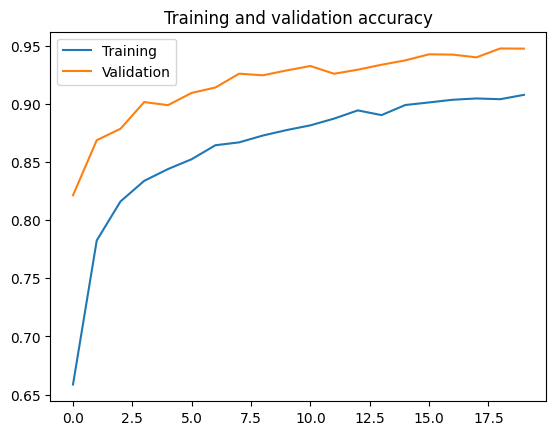

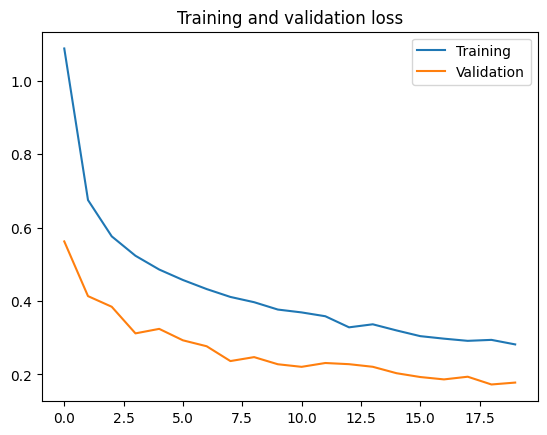

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [15]:
import time
curr_time = int(time.time())
saved_model_path = f"./models/{curr_time}-flowers.h5"

model.save(saved_model_path)
model.save(saved_model_path[:-3])

INFO:tensorflow:Assets written to: ./models/1686778501-flowers\assets


INFO:tensorflow:Assets written to: ./models/1686778501-flowers\assets


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3133c267-f23a-438d-afbc-fca39635b29d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>